In [12]:
from typing import Tuple, Dict, Callable, Iterator, Union, Optional, List
import os
import sys
import yaml 

import copy

import numpy as np
import torch
from torch import Tensor

# To import module code.
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.evaluate import (
    sort_rewards_global_optimization, 
    postprocessing_interpolation_rewards, 
    f_max_new
)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [13]:
def postprocess_data(configs: List[str], 
                    experiment_path: int,
                    sort_rewards: bool = True,
                    interpolate: bool = True, 
                    max_new: bool = True,
                    ):

    method_to_name = {'gibo': 'GIBO', 'rs': 'ARS', 'vbo': 'Vanilla BO', 'cmaes': 'CMA-ES', 'mpd': "MPD"}
    list_interpolated_rewards = []
    list_names_optimizer = []
    
    for cfg_str in configs:

        with open(cfg_str, 'r') as f:
            cfg = yaml.load(f, Loader=yaml.Loader)

        directory = '.'+ cfg['out_dir']
        
        if interpolate:

            print('Postprocess tracked parameters over optimization procedure.')

            # Load data.
            print(f'Load data from {directory}.')
            
            parameters = np.load(
                os.path.join(directory, 'parameters.npy'), allow_pickle=True
            ).item()
            rewards = np.load(
                os.path.join(directory, 'rewards.npy'), allow_pickle=True
            ).item()
            calls = np.load(
                os.path.join(directory, 'calls.npy'), allow_pickle=True
            ).item()
            
            if sort_rewards:
                rewards = sort_rewards_global_optimization(rewards)

            # Postprocess data (offline evaluation and interpolation).
            print('Postprocess data: interpolate.')
            interpolated_rewards = postprocessing_interpolation_rewards(
                rewards, calls, calls_of_objective=cfg['max_objective_calls']
            )

            # Save postprocessed data.
            print(f'Save postprocessed data in {directory}.')
            torch.save(
                interpolated_rewards, os.path.join(directory, 'interpolated_rewards.pt')
            )

        else:
            interpolated_rewards = torch.load(
                os.path.join(directory, 'interpolated_rewards.pt')
            )
            
        list_names_optimizer.append(method_to_name[cfg['method']])
        list_interpolated_rewards.append(interpolated_rewards)
    
    f_max_dict = torch.load(experiment_path + '/f_max.pt')
    if max_new:
        f_max_dict_new = f_max_new(f_max_dict, list_interpolated_rewards)
        
    return list_names_optimizer, list_interpolated_rewards, f_max_dict_new

In [14]:
(list_names_optimizer, 
 list_interpolated_rewards, 
 f_max_dict_new) = postprocess_data(configs=['../configs/synthetic_experiment/mpd_default.yaml'
                                            #  '../configs/synthetic_experiment/110620/vbo.yaml',
                                            #  '../configs/synthetic_experiment/110620/cmaes.yaml',
                                             ],
                                    experiment_path='../experiments/synthetic_experiments/test_experiment/',
                                    sort_rewards=True,
                                    interpolate=True)

Postprocess tracked parameters over optimization procedure.
Load data from ../experiments/synthetic_experiments/test_experiment/mpd/.
Postprocess data: interpolate.
Save postprocessed data in ../experiments/synthetic_experiments/test_experiment/mpd/.


In [4]:
(list_names_optimizer_optim, 
 list_interpolated_rewards_optim, 
 f_max_dict_new_optim) = postprocess_data(configs=['../configs/synthetic_experiment/110620/rs_optimize.yaml', 
                                                   '../configs/synthetic_experiment/110620/vbo_optimize.yaml',
                                                   '../configs/synthetic_experiment/110620/cmaes_optimize.yaml',
                                                   '../configs/synthetic_experiment/100621/gibo_optimize.yaml'],
                                          experiment_path='../experiments/synthetic_experiments/110620/',
                                          sort_rewards=True,
                                          interpolate=False)

In [ ]:
reward

In [31]:
f_max_dict_new

{3: [1.1234830617904663,
  2.481600522994995,
  2.0103886127471924,
  1.2259324789047241,
  1.7057310342788696],
 6: [2.146623134613037,
  1.2265617847442627,
  1.6961514949798584,
  1.3529884815216064,
  1.7332277297973633]}

In [32]:
def plot_function_value_distances(
    f_max: Dict,
    rewards_optimizers: List[Tensor],
    names_optimizers: List[str],
    figsize: Tuple[Union[int, float]],
    row_col: Tuple[int] = (2, 4),
    path_savefig: Optional[str] = None,
    remove_dim_index: Optional[List[int]] = None,
    show_std: bool = False,
):
    markers = ["D", "o", "s", ">"]
    dimensions = list(f_max.keys())
    dim_indices = torch.arange(0, len(dimensions))
    
    if remove_dim_index is not None:
        for rd in remove_dim_index:
            dimensions.pop(rd)
            dim_indices = dim_indices[dim_indices!=rd]
        
    num_objective_calls = rewards_optimizers[0].shape[-1]
    num_optimizers = len(rewards_optimizers)
    n_rows, n_cols = row_col
    fig, axs = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=figsize)
    fig.subplots_adjust(hspace=0.3)
    axs = np.array(axs).reshape(-1)
    
    for index_dim, dim in enumerate(dimensions):
        f_max_dim = f_max[dimensions[index_dim]]
        f_max_reshaped = torch.reshape(torch.tensor(f_max_dim), (-1, 1))
        if not show_std:
            axs[index_dim].set_yscale("log")
        if index_dim > n_cols * (n_rows - 1) - 1:
            axs[index_dim].set_xlabel("\# of evaluations", labelpad=10)
        if index_dim in [row * n_cols for row in range(n_rows)]:
            axs[index_dim].set_ylabel(r"$\frac{f^* - \widehat{f^*}}{f^*}$")
        axs[index_dim].set_title(f"{dim}-dim. domain", fontsize=10)
        axs[index_dim].set_xlim([0, num_objective_calls])
        # axs[index_dim].set_xticks([0, 100, 200, 300])
        
        
        for index_optimizer, rewards in enumerate(rewards_optimizers):
            value_error = f_max_reshaped - rewards[dim_indices, :, :][index_dim]
            value_error_normalized = value_error / f_max_reshaped
            mean = torch.mean(value_error_normalized, dim=0)
            std = torch.std(value_error_normalized, dim=0)
            axs[index_dim].plot(
                torch.linspace(0, num_objective_calls, num_objective_calls),
                mean,
                label=names_optimizers[index_optimizer],
                marker=markers[index_optimizer],
                linestyle="-",
                linewidth=1.,
                markersize=3,
                markeredgewidth=0.6,
                markevery=25,
                fillstyle="none",
            )
            if show_std:
                #relative_error = 0.434 * std / mean
                axs[index_dim].fill_between(
                    torch.linspace(0, num_objective_calls, num_objective_calls),
                    mean - std,
                    mean + std,
                    alpha=0.2,
                )
            axs[index_dim].yaxis.grid(True, which="minor", linewidth=.4)
    handles, labels = axs[index_dim].get_legend_handles_labels()
    lgd = fig.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.1),
        ncol=num_optimizers,
        frameon=False,
    )
    if path_savefig:
        plt.savefig(path_savefig, bbox_inches="tight", bbox_extra_artists=[lgd])
    return fig

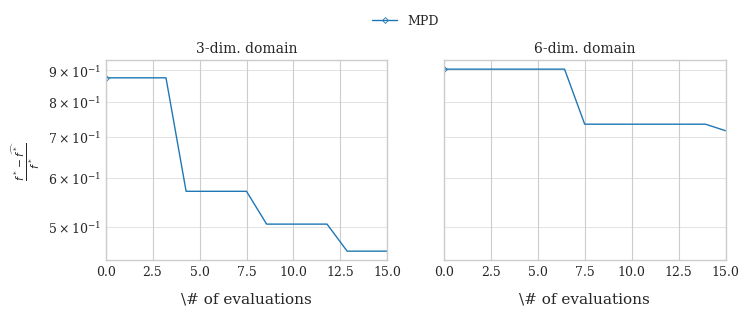

In [33]:
plot_function_value_distances(f_max=f_max_dict_new,
                              rewards_optimizers=list_interpolated_rewards,
                              names_optimizers=list_names_optimizer,
                              row_col=(1, 2),
                              figsize=(8,2.6),
                              path_savefig=None,#'../experiments/synthetic_experiments/100621/figures/fve_w_std.pdf',
                              remove_dim_index=None, 
                              show_std=False);

In [ ]:

def function_value_error_over_dimensions(
    f_max: Dict[int, List[int]],
    list_rewards_optimizers: List[Dict[int, List[list]]],
    list_names_optimizers: List[Dict[int, List[list]]],
    figsize: Tuple[Union[int, float]],
    path_savefig: Optional[str] = None,
    log_scale: bool = False,
):
    dimensions = list(f_max.keys())
    num_objectives = len(f_max[dimensions[0]])
    num_optimizers = len(list_rewards_optimizers)
    fve = torch.empty(len(list_rewards_optimizers), len(dimensions), num_objectives)
    f, axs = plt.subplots(1, num_optimizers, sharex=True, sharey=True, figsize=figsize)
    axs = np.array(axs).reshape(1, num_optimizers)
    for index_optimizer, rewards_optimizer in enumerate(list_rewards_optimizers):
        for dim_index, dim in enumerate(dimensions):
            global_max = torch.tensor(f_max[dim])
            max_rewards = torch.max(rewards_optimizer[dim_index], axis=-1).values
            value_error_normalized = (global_max - max_rewards) / global_max
            fve[index_optimizer][dim_index] = value_error_normalized

        medianprops = dict(linestyle='-', linewidth=0.8, color='black')
        meanprops = dict(marker='o', markerfacecolor='green', markersize=2,markeredgecolor='none')
        parts = axs[0, index_optimizer].boxplot(fve[index_optimizer], 
                                                positions=dimensions,
                                                widths=2.5,
                                                showfliers=False,
                                                showmeans=True,
                                                #meanline=True,
                                                meanprops=meanprops,
                                                medianprops=medianprops)
        if log_scale:
            axs[0, index_optimizer].set_yscale("log")
            axs[0, index_optimizer].set_ylim([3e-3, 5e-0])
            axs[0, index_optimizer].set_yticks([1e-0, 1e-1, 1e-2])
            axs[0, index_optimizer].yaxis.grid(True, which="minor", linewidth=.4)
        else:
            axs[0, index_optimizer].set_ylim([-0.05,1.05])
            axs[0, index_optimizer].set_yticks([0., 0.25, 0.5, 0.75, 1.])
        plt.xticks(dimensions[::2], dimensions[::2])
        #plt.xticks(dimensions, dimensions)
        
        axs[0, index_optimizer].set_xlabel("dimensions", labelpad=10)
        axs[0, index_optimizer].set_title(
            list_names_optimizers[index_optimizer], fontsize=10
        )

    axs[0, 0].set_ylabel(r"$\frac{f^* - \widehat{f^*}}{f^*}$")
    if path_savefig:
        plt.savefig(path_savefig, bbox_inches="tight")
    return fve, f

In [16]:
plt.style.use('seaborn-whitegrid')
tex_fonts = {
    # Use LaTeX to write all text
    # "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
}

plt.rcParams.update(tex_fonts)

In [17]:
list_names_optimizer

['MPD']

In [30]:
list_interpolated_rewards[0][0]

tensor([[-0.4110, -0.4110, -0.4110, -0.4110,  0.1097,  0.1097,  0.1097,  0.1097,
          0.3822,  0.3822,  0.3822,  0.3822,  0.3822,  0.3822,  0.3822],
        [ 1.0186,  1.0186,  1.0186,  1.0186,  1.0186,  1.0186,  1.0186,  1.0186,
          1.1373,  1.1373,  1.1373,  1.1373,  1.1552,  1.1552,  1.1552],
        [ 1.0625,  1.0625,  1.0625,  1.0625,  1.1711,  1.1711,  1.1711,  1.1711,
          1.1711,  1.1711,  1.1711,  1.1711,  1.2759,  1.2759,  1.2759],
        [ 0.0428,  0.0428,  0.0428,  0.0428,  0.5920,  0.5920,  0.5920,  0.5920,
          0.6420,  0.6420,  0.6420,  0.6420,  0.7659,  0.7659,  0.7659],
        [ 0.0327,  0.0327,  0.0327,  0.0327,  0.9751,  0.9751,  0.9751,  0.9751,
          0.9751,  0.9751,  0.9751,  0.9751,  1.1174,  1.1174,  1.1174]])

In [20]:
plot_function_value_distances(f_max=f_max_dict_new_optim,
                              rewards_optimizers=list_interpolated_rewards_optim,
                              names_optimizers=list_names_optimizer_optim,
                              row_col=(1, 2),
                              figsize=(8,2.6),
                              path_savefig=False, #'../experiments/synthetic_experiments/100621/figures/fve_optimize_w_std.pdf',
                              remove_dim_index=[2],
                              show_std=False);

NameError: name 'f_max_dict_new_optim' is not defined

In [9]:
plt.style.use('seaborn-whitegrid')
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8.5,
    "ytick.labelsize": 8.5}

plt.rcParams.update(tex_fonts)

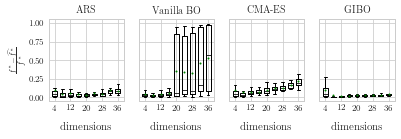

In [10]:
plt.rcParams['lines.linewidth'] = 1.
fve = function_value_error_over_dimensions(f_max=f_max_dict_new,
                                           list_rewards_optimizers=list_interpolated_rewards,
                                           list_names_optimizers=list_names_optimizer,
                                           figsize=(6.2,1.5),
                                           path_savefig=None #'../experiments/synthetic_experiments/100621/figures/boxplots.pdf'
                                          )

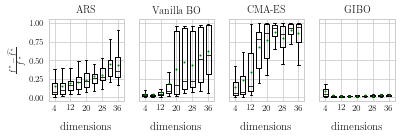

In [11]:
plt.rcParams['lines.linewidth'] = 1.
fve = function_value_error_over_dimensions(f_max=f_max_dict_new_optim,
                                           list_rewards_optimizers=list_interpolated_rewards_optim,
                                           list_names_optimizers=list_names_optimizer_optim,
                                           figsize=(6.2,1.5),
                                           path_savefig=None #'../experiments/synthetic_experiments/100621/figures/boxplots_optimize.pdf'
                                          )